**************
Importing modules
**************
Importing JSON Guitars
Getting started training model on 14431 historical auctions


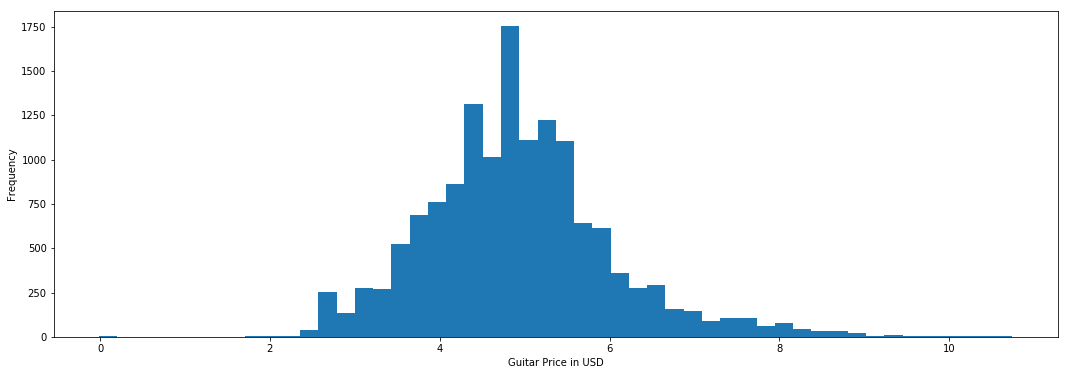

In [24]:
stars = '**************'
print(stars)
print('Importing modules')

import os, operator, itertools, pickle, sys, string
from copy import copy

import numpy as np
import pandas as pd
# pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_selection import f_regression, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.pipeline import make_pipeline, make_union

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from tpot.builtins import StackingEstimator
import xgboost

np.random.seed(0)

sys.path.insert(0, 'objects')
sys.path.insert(0, 'data')
sys.path.insert(0, 'pickles')

from Shade_Sale import Shade_Sale

print(stars)
print('Importing JSON Guitars')

file_names = [name for name in os.listdir('data/specs/') if not name.startswith('.')] # Ignores hidden files on mac

items = []
for filename in file_names:
    try:
        this_item = Shade_Sale('data/listings', 'data/specs', filename)
        if "LOT" not in this_item.title.upper() and this_item.country_seller == 'US' and this_item.price < 1500:# and this_item.price > 50:
            items.append(this_item)
    except ValueError:
        print('valerror')
        pass
    
print(f'Getting started training model on {len(items)} historical auctions')

orig_prices = pd.Series([item.price for item in items], name = 'prices')

bxcx_lam = .1
prices = pd.Series(boxcox([item.price for item in items], lmbda=bxcx_lam), name = 'prices')
plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

In [2]:
title_lengths       = pd.Series([item.len_title for item in items], name = 'title_lengths')
auction_duration    = pd.cut(pd.Series([item.duration/24 for item in items], name = 'auction_duration'),[0,1,2,4,6,7])
shipping_charged    = pd.Series([item.price_shipping for item in items], name = 'shipping_charged')
autopay             = pd.Series([item.autopay for item in items], name = 'autopay')
returns             = pd.Series([item.returns for item in items], name = 'returns')
listing_type        = pd.Series([item.listing_type for item in items], name = 'listing_type')
ship_type           = pd.Series([item.ship_type for item in items], name = 'ship_type')
ship_expedite       = pd.Series([item.ship_expedite for item in items], name = 'ship_expedite')
start_hour          = pd.cut(pd.Series([item.start_time.hour for item in items], name = 'start_hour'), 6)
end_hour            = pd.cut(pd.Series([item.end_time.hour for item in items], name = 'end_hour'), 6)
start_weekday       = pd.Series([item.start_weekday for item in items], name = 'start_weekday').astype('category')
end_weekday         = pd.Series([item.end_weekday for item in items], name = 'end_weekday').astype('category')
returns_time        = pd.Series([item.returns_time for item in items], name = "returns_time").astype('category')
num_pics            = pd.cut(pd.Series([item.pic_quantity for item in items], name = "num_pics"),[0,3,5,7,9,12])
brand               = pd.Series([item.brand for item in items], name = "brand")
frame_color         = pd.Series([item.frame_color for item in items], name = "frame_color")
lens_color          = pd.Series([item.lens_color for item in items], name = "lens_color")
frame_material      = pd.Series([item.frame_material for item in items], name = "frame_material")
lens_tech           = pd.Series([item.lens_tech for item in items], name = "lens_tech")
best_offer_enabled  = pd.Series([item.best_offer_enabled for item in items], name = "best_offer_enabled")
country_manufacture = pd.Series([item.country_manufacture for item in items], name = "country_manufacture")
temple_length_listed= pd.Series([item.temple_length_binary for item in items], name = "temple_length_listed")
style               = pd.Series([item.style for item in items], name = "style")
protection          = pd.Series([item.protection for item in items], name = "protection")

ship_handling_time = pd.cut(pd.Series([item.ship_handling_time for item in items], name = 'ship_handling_time'), [-1,0,1,2,3,50])

feedback_lmbda = -.02
seller_feedback_score_boxed = pd.Series(boxcox([item.seller_feedback_score + 5 for item in items], lmbda=feedback_lmbda), name='seller_feedback_score_boxed')

In [3]:
# ## Text as a Regression Feature
# http://www-stat.wharton.upenn.edu/~stine/research/regressor.pdf
def assemble_guitar_document(item):
    document = item.title + ' '
    if item.frame_color != 'UNLISTED':
        document += item.frame_color + ' '
    if item.lens_color != 'UNLISTED':
        document += item.lens_color + ' '
    if item.frame_material != 'UNLISTED':
        document += item.frame_material + ' '
    if item.model != 'UNLISTED':
        document += item.model + ' ' 
    if item.style != 'UNLISTED':
        document += item.style + ' '
    if item.brand != 'UNLISTED':
        document += item.brand + ' '
    if item.lens_tech != 'UNLISTED':
        document += item.lens_tech + ' '
    if item.protection != 'UNLISTED':
        document += item.protection + ' '
    if item.subtitle != None:
        document += item.subtitle + ' '
    if item.condition_description != None:
        document += item.condition_description + ' '
    if item.description != None:
        document += item.description
    return document

In [4]:
raw_corpus = [assemble_guitar_document(item).lower() for item in items]

stemmer = SnowballStemmer("english")

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', ",", ".", ":", "'s", "--","’"]

def process_doc(doc):
    stopwords_removed = ''
    tokens = nltk.word_tokenize(doc)
    for i in range(len(tokens)):
        if tokens[i].lower() not in stopwords_list and tokens[i] not in string.punctuation:
            stopwords_removed += stemmer.stem(tokens[i]) + ' '
    return stopwords_removed

print(stars)
print('Processing Text Corpus...')

processed_text = pd.Series(list(map(process_doc, raw_corpus)), 
                           name = 'text')

**************
Processing Text Corpus...


In [5]:
# ## Assemble the Feature Set
X_dummies = pd.concat([title_lengths, 
                       brand, 
                       frame_color, 
                       frame_material, 
                       lens_color,
                       lens_tech,
                       country_manufacture, 
                       best_offer_enabled, 
                       shipping_charged, 
                       returns,
                       returns_time,
                       autopay, 
                       ship_handling_time, 
                       listing_type, 
                       ship_expedite,
                       ship_type, 
                       num_pics, 
                       auction_duration, 
                       start_hour, 
                       end_hour, 
                       start_weekday, 
                       end_weekday, 
                       seller_feedback_score_boxed,
                       style,
                       protection,
                       temple_length_listed],
              axis = 1)

X = pd.get_dummies(X_dummies, drop_first=True)

In [7]:
# ### SPLIT

print(stars)
print('Splitting...')

X = pd.concat([X, processed_text], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, prices, test_size=.20)#, random_state=42)

**************
Splitting...


In [8]:
# Text Features vectorization

print(stars)
print('Vectorizing Text...')

vectorizer = TfidfVectorizer(norm=None, ngram_range=(2,3), strip_accents='ascii',
#                             max_df=0.8, min_df=2,
                             max_features=300)

vectorizer.fit(X_train['text'])

outfile = open('pickles/saved_vectorizer','wb')
pickle.dump(vectorizer,outfile)
outfile.close()

tfidf_train = vectorizer.transform(X_train['text'])
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=vectorizer.get_feature_names())

tfidf_test = vectorizer.transform(X_test['text'])
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=vectorizer.get_feature_names())

X_train_to_scale = pd.concat([X_train.reset_index(drop=True), tfidf_train_df], axis=1).drop('text',axis=1)
X_test_to_scale = pd.concat([X_test.reset_index(drop=True), tfidf_test_df], axis=1).drop('text',axis=1)

**************
Vectorizing Text...


In [9]:
print(stars)
print('Scaling...')

# ### Scale It 
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_to_scale), columns=X_train_to_scale.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_to_scale), columns=X_test_to_scale.columns)

outfile = open('pickles/saved_scaler','wb')
pickle.dump(scaler,outfile)
outfile.close()

**************
Scaling...


/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [10]:
# ### Generate a Tensorboard Projector Visualization:

# import tensorflow as tf
# from tensorflow.contrib.tensorboard.plugins import projector
# board_data = pd.DataFrame(vectorizer.transform(processed_text).toarray(), 
#                           columns = vectorizer.get_feature_names())
# board_data.shape
# LOG_DIR = 'logs'
# board_data_tf = tf.Variable(board_data, name='board_data_tf')
# metadata = os.path.join(LOG_DIR, 'metadata.tsv')
# with open(metadata, 'w') as metadata_file:
#     for row in [item.title[:25] for item in items]:
#         metadata_file.write('%s\n' % row)
# with tf.Session() as sess:
#     saver = tf.train.Saver([board_data_tf])
#     sess.run(board_data_tf.initializer)
#     saver.save(sess, os.path.join(LOG_DIR, 'board_data_tf.ckpt'))
#     config = projector.ProjectorConfig()
#     # One can add multiple embeddings.
#     embedding = config.embeddings.add()
#     embedding.tensor_name = board_data_tf.name
#     # Link this tensor to its metadata file (e.g. labels).
#     embedding.metadata_path = metadata
#     # Saves a config file that TensorBoard will read during startup.
#     projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [11]:
# ### Baseline Naive Error - Guess the Mean Price
price_mean = np.mean(y_train)
price_mean_vector = inv_boxcox([price_mean for i in range(len(y_test))],bxcx_lam)
baseline_error = np.sqrt(mean_squared_error(inv_boxcox(y_test, bxcx_lam), price_mean_vector))
print(f'Baseline error to beat is ${round(baseline_error,2)} RMSE')

Baseline error to beat is $78.28 RMSE


In [12]:
print(stars)
print('Pickling columns...')

filename = 'pickles/bonus_columns'
outfile = open(filename, 'wb')
pickle.dump(list(X_train_scaled.columns), outfile)
outfile.close()

**************
Pickling columns...


In [13]:
X_train_scaled.shape

(11544, 399)

In [14]:
print(stars)
print('Training a Lasso Regressor...')

# ### Lasso Regression
lasso_model = LassoCV(cv=3).fit(X_train_scaled, y_train)

outfile = open('pickles/lasso_model','wb')
pickle.dump(lasso_model,outfile)
outfile.close()

**************
Training a Lasso Regressor...


/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/.local/share/virtual

/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/.local/share/virtualenvs/ebay_valuator-vRvGBMQn/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/.local/share/virtual

Lasso train_error is 70.91650736672733, lasso test_error is 65.27474290883575

Lasso Train error is a 9.41% improvement over guessing the mean. 

Lasso Test error is a 16.61% improvement over guessing the mean.


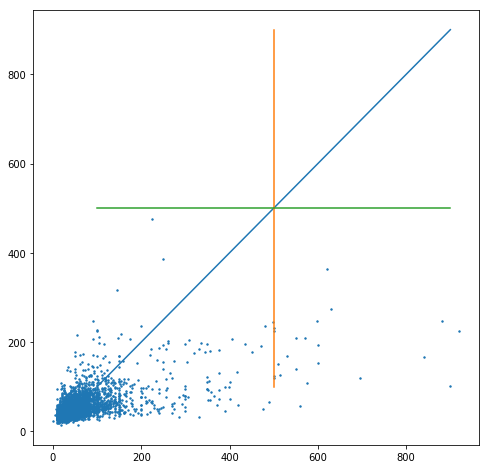

In [15]:
y_train_preds = lasso_model.predict(X_train_scaled)
y_test_preds = lasso_model.predict(X_test_scaled)

y_train_inv = inv_boxcox(y_train, bxcx_lam)
y_test_inv = inv_boxcox(y_test, bxcx_lam)

y_train_preds_inv = inv_boxcox(y_train_preds, bxcx_lam)
y_test_preds_inv = inv_boxcox(y_test_preds, bxcx_lam)

train_error = np.sqrt(mean_squared_error(y_train_inv, y_train_preds_inv))
test_error = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_inv))

print(f'Lasso train_error is {train_error}, lasso test_error is {test_error}\n')

print(f'Lasso Train error is a {round((((baseline_error - train_error) / baseline_error) * 100),2)}% improvement over guessing the mean. \n')

print(f'Lasso Test error is a {round((((baseline_error - test_error) / baseline_error) * 100),2)}% improvement over guessing the mean.')

plt.figure(figsize=(8,8))
plt.scatter(y_test_inv, y_test_preds_inv, s=2)
x = np.linspace(100,900, num=2)
plt.plot(x,x)
plt.plot(np.full(len(x),500),x)
plt.plot(x,np.full(len(x),500))
plt.show()

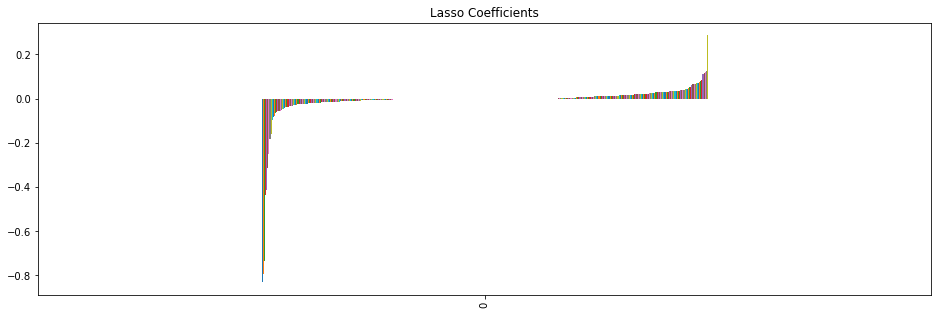

In [16]:
coef = pd.DataFrame(data = lasso_model.coef_, index=X_train_scaled.columns)
model_coef = coef.sort_values(by=0).T
model_coef.plot(kind='bar', title='Lasso Coefficients', legend=False, figsize=(16,5))
plt.show()

In [17]:
print(stars)
print('Writing out Lasso Coefs...')

t_mod = model_coef.T
lasso_feats = t_mod[abs(t_mod) > 0].dropna()
lasso_feats.to_csv('lasso_coefs.csv')


**************
Writing out Lasso Coefs...


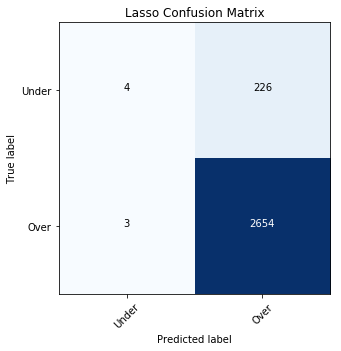

In [20]:
# Can I get a confusion matrix?

price_thresh = 20

high_actual = y_test_inv > price_thresh

high_preds = y_test_preds_inv > price_thresh
plt.figure(figsize=(5,5))
cnf_matrix = confusion_matrix(high_actual, high_preds)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Lasso Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Under', 'Over'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.show()

In [ ]:
## Fitting a TPOT Auto-ML Pipeline
from tpot import TPOTRegressor
pipeline_optimizer = TPOTRegressor(generations=80, population_size=100,
                          offspring_size=None, mutation_rate=0.9,
                          crossover_rate=0.1,
                          scoring='neg_mean_squared_error', cv=5,
                          subsample=1.0, n_jobs=8,
                          max_time_mins=540, max_eval_time_mins=7,
                          random_state=None, config_dict='TPOT sparse',
                          warm_start=False,
                          memory=None,
                          use_dask=False,
                          periodic_checkpoint_folder='TPOT_saves',
                          early_stop=None,
                          verbosity=3,
                          disable_update_check=False)

X_train_scaled_tpot = X_train_scaled.values.astype('float')

### This is where you use TPOT to train a model
pipeline_optimizer.fit(X_train_scaled_tpot, y_train)

# # Export:
pipeline_optimizer.export('pickles/tpot_guitar_pipeline.py')

11 operators have been imported by TPOT.


Skipped pipeline #17 due to time out. Continuing to the next pipeline.


In [ ]:
# input("Press Enter to continue...")

# ### Import TPOT-Selected Model
# (Copy paste ideal pipeline from tpot_guitar_pipeline.py file)

tpot = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        StackingEstimator(estimator=RidgeCV())
    ),
    RandomForestRegressor(bootstrap=False, max_features=0.05, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
)

print(stars)
print('Training TPOT Pipeline...')

tpot.fit(X_train_scaled_tpot, y_train)

print(stars)
print('Pickling the TPOT...')

filename = 'pickles/tpot'
outfile = open(filename, 'wb')
pickle.dump(tpot, outfile)
outfile.close()

In [ ]:
y_train_preds_tpot = tpot.predict(X_train_scaled.values.astype('float'))
y_test_preds_tpot = tpot.predict(X_test_scaled.values.astype('float'))

y_train_preds_inv_tpot = inv_boxcox(y_train_preds_tpot, bxcx_lam)
y_test_preds_inv_tpot = inv_boxcox(y_test_preds_tpot, bxcx_lam)

train_error_tpot = np.sqrt(mean_squared_error(y_train_inv, y_train_preds_inv_tpot))
test_error_tpot = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_inv_tpot))

print(f'TPOT Train RMSE: {round(train_error_tpot, 2)} --- Test RMSE: {round(test_error_tpot, 2)}\n')

print(f'TPOT Train error is a {round((((baseline_error - train_error_tpot) / baseline_error) * 100),2)}% improvement over guessing the mean. \n')

print(f'TPOT Test error is a {round((((baseline_error - test_error_tpot) / baseline_error) * 100),2)}% improvement over guessing the mean.')

plt.figure(figsize=(8,8))
plt.scatter(y_test_inv, y_test_preds_inv_tpot, s=2)
x = np.linspace(100,900, num=2)
plt.plot(x,x)
plt.plot(np.full(len(x),500),x)
plt.plot(x,np.full(len(x),500))
plt.show()

In [ ]:
price_thresh = 50

high_preds_tpot = y_test_preds_inv_tpot > price_thresh
plt.figure(figsize=(5,5))
cnf_matrix_tpot = confusion_matrix(high_actual, high_preds_tpot)
plt.imshow(cnf_matrix_tpot,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('TPOT Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Under', 'Over'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix_tpot.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix_tpot.shape[0]), range(cnf_matrix_tpot.shape[1])):
        plt.text(j, i, cnf_matrix_tpot[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix_tpot[i, j] > thresh else "black")

plt.show()

print(f'TPOT model only identifies {round(100 * cnf_matrix_tpot[1][1] / (cnf_matrix_tpot[1][0] + cnf_matrix_tpot[1][1]), 2)}% of the guitars that will sell above ${price_thresh}.')

print(f'However, when TPOT guesses above ${price_thresh}, it\'s correct {round((cnf_matrix_tpot[1][1] / (cnf_matrix_tpot[1][1] + cnf_matrix_tpot[0][1]))*100, 2)}% of the time.')